<a href="https://colab.research.google.com/github/dawmro/pytorch_tutorial/blob/main/Image_Classification_Pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Initializations and Dataset Download

In [1]:
# Install the opendatasets library for downloading datasets.
!pip install opendatasets

In [2]:

import opendatasets as od
od.download("https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: dmrotek111@gmail.com
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification


# 2. Imports

In [16]:
import torch # Main PyTorch Library
from torch import nn # Used for creating the layers and loss function
from torch.optim import Adam # Adam Optimizer
import torchvision.transforms as transforms # Transform function used to modify and preprocess all the images
from torchvision import models # import pretrained models in PyTorch library
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
from PIL import Image # Used to read the images from the directory
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations
import os # Used to read the images path from the directory

device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac
print("Device available: ", device)

Device available:  cuda


# 3. Reading Data Paths

In [4]:
train_df = pd.read_csv("/content/bean-leaf-lesions-classification/train.csv")
val_df = pd.read_csv("/content/bean-leaf-lesions-classification/val.csv")

data_df = pd.concat([train_df, val_df], ignore_index=True)

data_df["image:FILE"] = "/content/bean-leaf-lesions-classification/" + data_df["image:FILE"]

print("Data shape is: ", data_df.shape)
print()
data_df.head()


Data shape is:  (1167, 2)



,image:FILE,category
0,/content/bean-leaf-lesions-classification/trai...,0
1,/content/bean-leaf-lesions-classification/trai...,0
2,/content/bean-leaf-lesions-classification/trai...,0
3,/content/bean-leaf-lesions-classification/trai...,0
4,/content/bean-leaf-lesions-classification/trai...,0


# 4. Data Inspection

In [5]:
print("Classes are: ")
print(data_df["category"].unique())
print()
print("Classes ditrubution are: ")
print(data_df["category"].value_counts())

Classes are: 
[0 1 2]

Classes ditrubution are: 
category
2    393
1    389
0    385
Name: count, dtype: int64


# 5. Data Split

In [6]:
train=data_df.sample(frac=0.7,random_state=7) # Create training of 70% of the data
test=data_df.drop(train.index) # Create testing by removing the 70% of the train data which will result in 30%

# 6. Preprocessing Objects

In [7]:
label_encoder = LabelEncoder() # Encode the string classes to numeric

transform = transforms.Compose([
    transforms.Resize((128, 128)), # One size for all images
    transforms.ToTensor(), # Convert images to PyTorch tensors
    transforms.ConvertImageDtype(torch.float), # The values are in floating point numbers
    ]) # Transform all images into one clear format (preprocess all images to same properties)

# 7. Custom Dataset Class

In [9]:
class CustomImageDataset(Dataset):
  """
  A custom dataset class for loading and preprocessing images.

  Args:
    dataframe (pd.DataFrame): The dataframe containing image paths and labels.
    transform (callable, optional): A function/transform that takes in an PIL image
      and returns a transformed version. E.g, `transforms.ToTensor`. Defaults to None.
  """
  def __init__(self, dataframe, transform=None):
    self.dataframe = dataframe
    self.transform = transform
    # Encode labels and move to device
    self.labels = torch.tensor(label_encoder.fit_transform(dataframe['category'])).to(device)

  def __len__(self):
    """
    Returns the number of samples in the dataset.
    """
    return self.dataframe.shape[0]

  def __getitem__(self, idx):
    """
    Loads and preprocesses a single image and its label.

    Args:
      idx (int): The index of the sample to load.

    Returns:
      tuple: A tuple containing the image and its label.
    """
    img_path = self.dataframe.iloc[idx, 0] # Get the image path from the dataframe
    label = self.labels[idx] # Get the corresponding label
    image = Image.open(img_path).convert('RGB') # Open the image and convert to RGB
    if self.transform:
      image = (self.transform(image)/255).to(device) # Apply the transform and move to device

    return image, label

# 8. Create Dataset Objects

In [11]:
train_dataset = CustomImageDataset(dataframe=train, transform=transform)
test_dataset = CustomImageDataset(dataframe=test, transform=transform)

# 9. Visualize Images

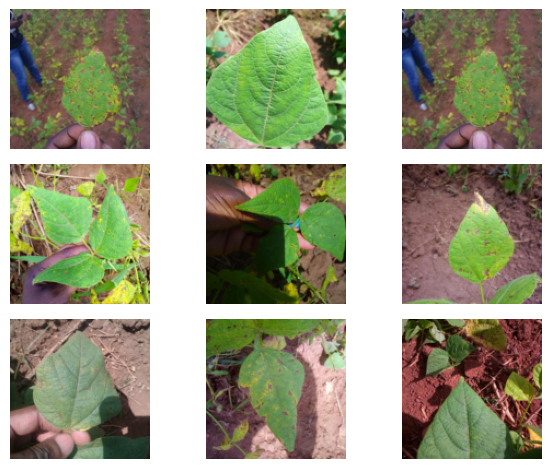

In [12]:
n_rows = 3
n_cols = 3
f, axarr = plt.subplots(n_rows, n_cols)
for row in range(n_rows):
    for col in range(n_cols):
        image = train_dataset[np.random.randint(0,train_dataset.__len__())][0].cpu()
        axarr[row, col].imshow((image*255).squeeze().permute(1,2,0))
        axarr[row, col].axis('off')

plt.tight_layout()
plt.show()

# 10. Hyperparameters

In [83]:
LR = 1e-3
BATCH_SIZE = 4
EPOCHS = 50

# 11. DataLoaders

In [84]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# 12. Model

In [85]:
googlenet_model = models.googlenet(weights='DEFAULT') # Load the pre-trained GoogleNet model with default weights
for param in googlenet_model.parameters():
  param.requires_grad = True # Set requires_grad to True for all parameters to enable fine-tuning

In [86]:
# Print the structure of the final fully connected layer
googlenet_model.fc

Linear(in_features=1024, out_features=1000, bias=True)

In [87]:
num_classes = len(data_df["category"].unique()) # Get the number of unique classes in the dataset
# Replace the final fully connected layer with a new one that has the correct number of output classes
googlenet_model.fc = torch.nn.Linear(googlenet_model.fc.in_features, num_classes)
googlenet_model.to(device) # Move the model to the selected device (GPU or CPU)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

# 13. Loss and Optimizer

In [88]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss() # Cross Entropy Loss
optimizer = Adam(googlenet_model.parameters(), lr=LR) # Adam optimizer

# 14. Training

In [89]:
# Initialize lists to store training loss and accuracy for each epoch
total_loss_train_plot = []
total_acc_train_plot = []
total_acc_test_plot = []

# Iterate over the specified number of epochs
for epoch in range(EPOCHS):
  # Initialize accumulators for training loss and accuracy for the current epoch
  total_acc_train = 0
  total_loss_train = 0

  # Iterate over the training data loader
  for batch_idx, (inputs, labels) in enumerate(train_loader):
    # Reset gradients to zero before each batch
    optimizer.zero_grad()

    # Forward pass: Get predictions from the model
    outputs = googlenet_model(inputs)

    # Calculate the loss
    train_loss = criterion(outputs, labels)

    # Accumulate the total loss for the epoch
    total_loss_train += train_loss.item()

    # Backward pass: Calculate gradients
    train_loss.backward()

    # Update model weights using the optimizer
    optimizer.step()

    # Calculate and accumulate the training accuracy for the batch
    train_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
    total_acc_train += train_acc

  # Calculate and store the average training loss and accuracy for the epoch
  avg_train_loss = total_loss_train / len(train_loader.dataset) # divided by the total number of training samples
  avg_train_acc = total_acc_train / len(train_loader.dataset) * 100 # Calculate average accuracy for the epoch
  total_loss_train_plot.append(round(avg_train_loss, 4))
  total_acc_train_plot.append(round(avg_train_acc, 4))

  # Print the training progress for the current epoch
  print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(avg_train_loss, 4)}, Train Accuracy: {round(avg_train_acc, 4)}%')

  # Evaluate the model on the test set
  with torch.no_grad(): # Disable gradient calculation during inference
    total_loss_test = 0
    total_acc_test = 0
    for indx, (input, labels) in enumerate(test_loader): # Iterate over the test data loader

      prediction = googlenet_model(input) # Get predictions from the model

      acc = (torch.argmax(prediction, axis = 1) == labels).sum().item() # Calculate the number of correct predictions
      total_acc_test += acc # Accumulate the total correct predictions
    total_acc_test_plot.append(round((total_acc_test/test_dataset.__len__())*100, 2))

  print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__())*100, 2)}%") # Print the overall accuracy
  print()

Epoch 1/50, Train Loss: 0.2474, Train Accuracy: 51.7748%
Accuracy Score is: 52.57%

Epoch 2/50, Train Loss: 0.2109, Train Accuracy: 60.2203%
Accuracy Score is: 68.86%

Epoch 3/50, Train Loss: 0.197, Train Accuracy: 66.2179%
Accuracy Score is: 57.71%

Epoch 4/50, Train Loss: 0.1869, Train Accuracy: 69.645%
Accuracy Score is: 67.14%

Epoch 5/50, Train Loss: 0.1805, Train Accuracy: 70.869%
Accuracy Score is: 59.71%

Epoch 6/50, Train Loss: 0.1835, Train Accuracy: 69.033%
Accuracy Score is: 60.0%

Epoch 7/50, Train Loss: 0.1743, Train Accuracy: 70.1346%
Accuracy Score is: 72.57%

Epoch 8/50, Train Loss: 0.1537, Train Accuracy: 74.0514%
Accuracy Score is: 75.71%

Epoch 9/50, Train Loss: 0.1406, Train Accuracy: 78.825%
Accuracy Score is: 69.14%

Epoch 10/50, Train Loss: 0.1445, Train Accuracy: 78.5802%
Accuracy Score is: 77.43%

Epoch 11/50, Train Loss: 0.1343, Train Accuracy: 77.2338%
Accuracy Score is: 74.86%

Epoch 12/50, Train Loss: 0.126, Train Accuracy: 81.5177%
Accuracy Score is: 76.5

# 15. Testing

In [90]:
# Evaluate the model on the test set
with torch.no_grad(): # Disable gradient calculation during inference
  total_loss_test = 0
  total_acc_test = 0
  for indx, (input, labels) in enumerate(test_loader): # Iterate over the test data loader

    prediction = googlenet_model(input) # Get predictions from the model

    acc = (torch.argmax(prediction, axis = 1) == labels).sum().item() # Calculate the number of correct predictions
    total_acc_test += acc # Accumulate the total correct predictions

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__())*100, 2)}%") # Print the overall accuracy

Accuracy Score is: 82.57%


# 16. Plotting Training Progress

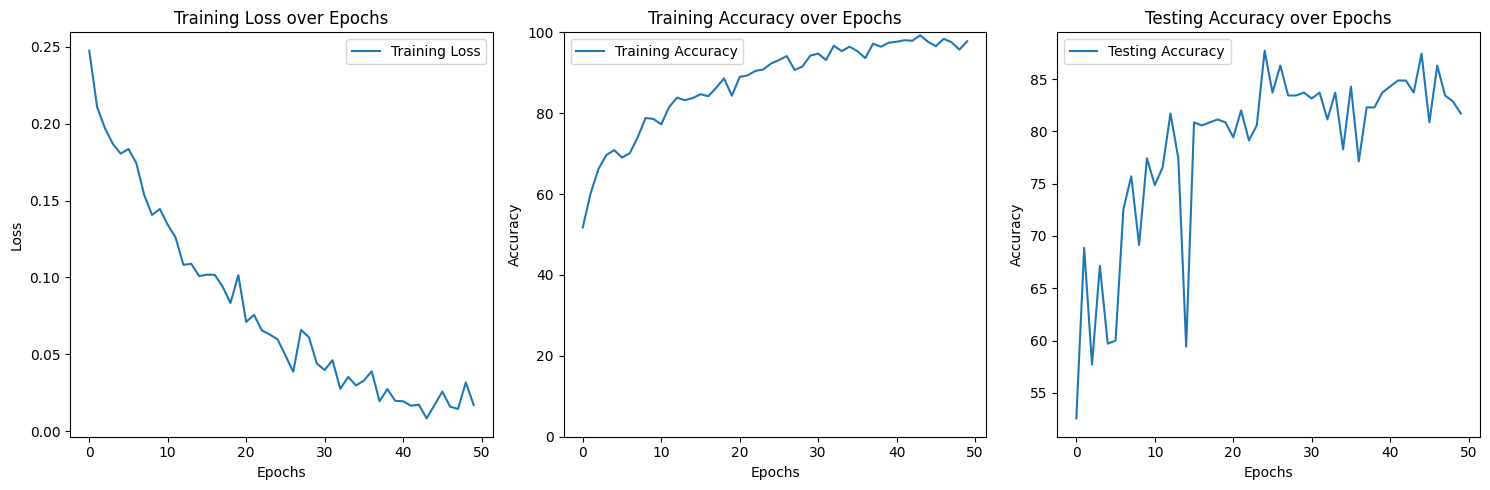

In [91]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].set_title('Training Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[1].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].set_title('Training Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

axs[2].plot(total_acc_test_plot, label='Testing Accuracy')
axs[2].set_title('Testing Accuracy over Epochs')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[2].legend()

plt.tight_layout()

plt.show()